  ![Görüntü Açıklaması](bafgan.png)

## Gerekli Kütüphanelerin Eklenmesi

In [11]:
import pickle
import torch
import pandas as pd
import torch.nn as nn
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import matplotlib.pyplot as plt
import time
from sklearn.preprocessing import MinMaxScaler
import pickle

## Veri Seti İçin Ön İşlemler

In [12]:
df = pd.read_csv('sample100.csv')  
data = pd.read_csv('sample100.csv') 

categorical_columns = ['income', 'customer_age', 'payment_type', 'employment_status', 'housing_status', 'source', 'device_os', 'device_distinct_emails_8w', 'device_fraud_count', 'month']

encoder = OneHotEncoder(sparse=False, drop='first')
encoded_df = pd.DataFrame(encoder.fit_transform(df[categorical_columns]))

encoded_df.columns = encoder.get_feature_names_out(categorical_columns)

df = df.drop(columns=categorical_columns)

df = pd.concat([df, encoded_df], axis=1)

fraud_bool = df['fraud_bool']

binary_columns = ["email_is_free","phone_home_valid","phone_mobile_valid","has_other_cards","foreign_request","keep_alive_session"]  # Binary sütunların isimleri
columns_to_scale = df.columns.difference(['fraud_bool'] + binary_columns)
scaler = MinMaxScaler()
scaled_df = df.copy()
scaled_df[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])

scaled_df['fraud_bool'] = fraud_bool
scaled_df[binary_columns] = df[binary_columns] 

In [22]:
scaled_new_df = scaled_df.copy()
encoded_new_df = encoded_df.copy()
new_categorical_columns = categorical_columns

  ## Generator ve Discriminator Sınıflarının Eklenmesi

In [23]:
class Generator(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, output_dim),
            nn.Tanh()
        )

    def forward(self, x):
        return self.model(x)

class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

## Kaydedilen Modelin Dahil Edilmesi

In [28]:
latent_dim = 1024
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


with open('generator_model.pkl', 'rb') as f:
    generator_state_dict = pickle.load(f)


generator = Generator(input_dim=latent_dim, output_dim=69).to(device)
generator.load_state_dict(generator_state_dict)


num_samples = 1000000  
noise = torch.randn(num_samples, latent_dim).to(device)


generated_data = generator(noise).detach().cpu().numpy()


generated_df = pd.DataFrame(generated_data, columns=scaled_new_df.columns) 


generated_df[columns_to_scale] = scaler.inverse_transform(generated_df[columns_to_scale])


generated_df[binary_columns] = (generated_df[binary_columns] > 0.5).astype(int)


categorical_output = pd.DataFrame(encoder.inverse_transform(generated_df[encoded_new_df.columns]))
categorical_output.columns = new_categorical_columns  


generated_df = generated_df.drop(columns=encoded_new_df.columns)  
generated_df = pd.concat([generated_df, categorical_output], axis=1) 

  ## Hedef Değişkenin Ayarlanması

In [29]:
generated_df["fraud_bool"] = generated_df["fraud_bool"].astype(int)

In [30]:
df_sorted = generated_df.sort_values(by='fraud_bool', ascending=False).reset_index()

df_sorted.loc[:9999, 'fraud_bool'] = 1  
df_sorted.loc[10000:, 'fraud_bool'] = 0  

generated_df['fraud_bool'] = df_sorted.sort_values(by='index').reset_index(drop=True)['fraud_bool']

## Üretilen Veri ile Yapay Veri Dağılımlarının Karşılaştırılması

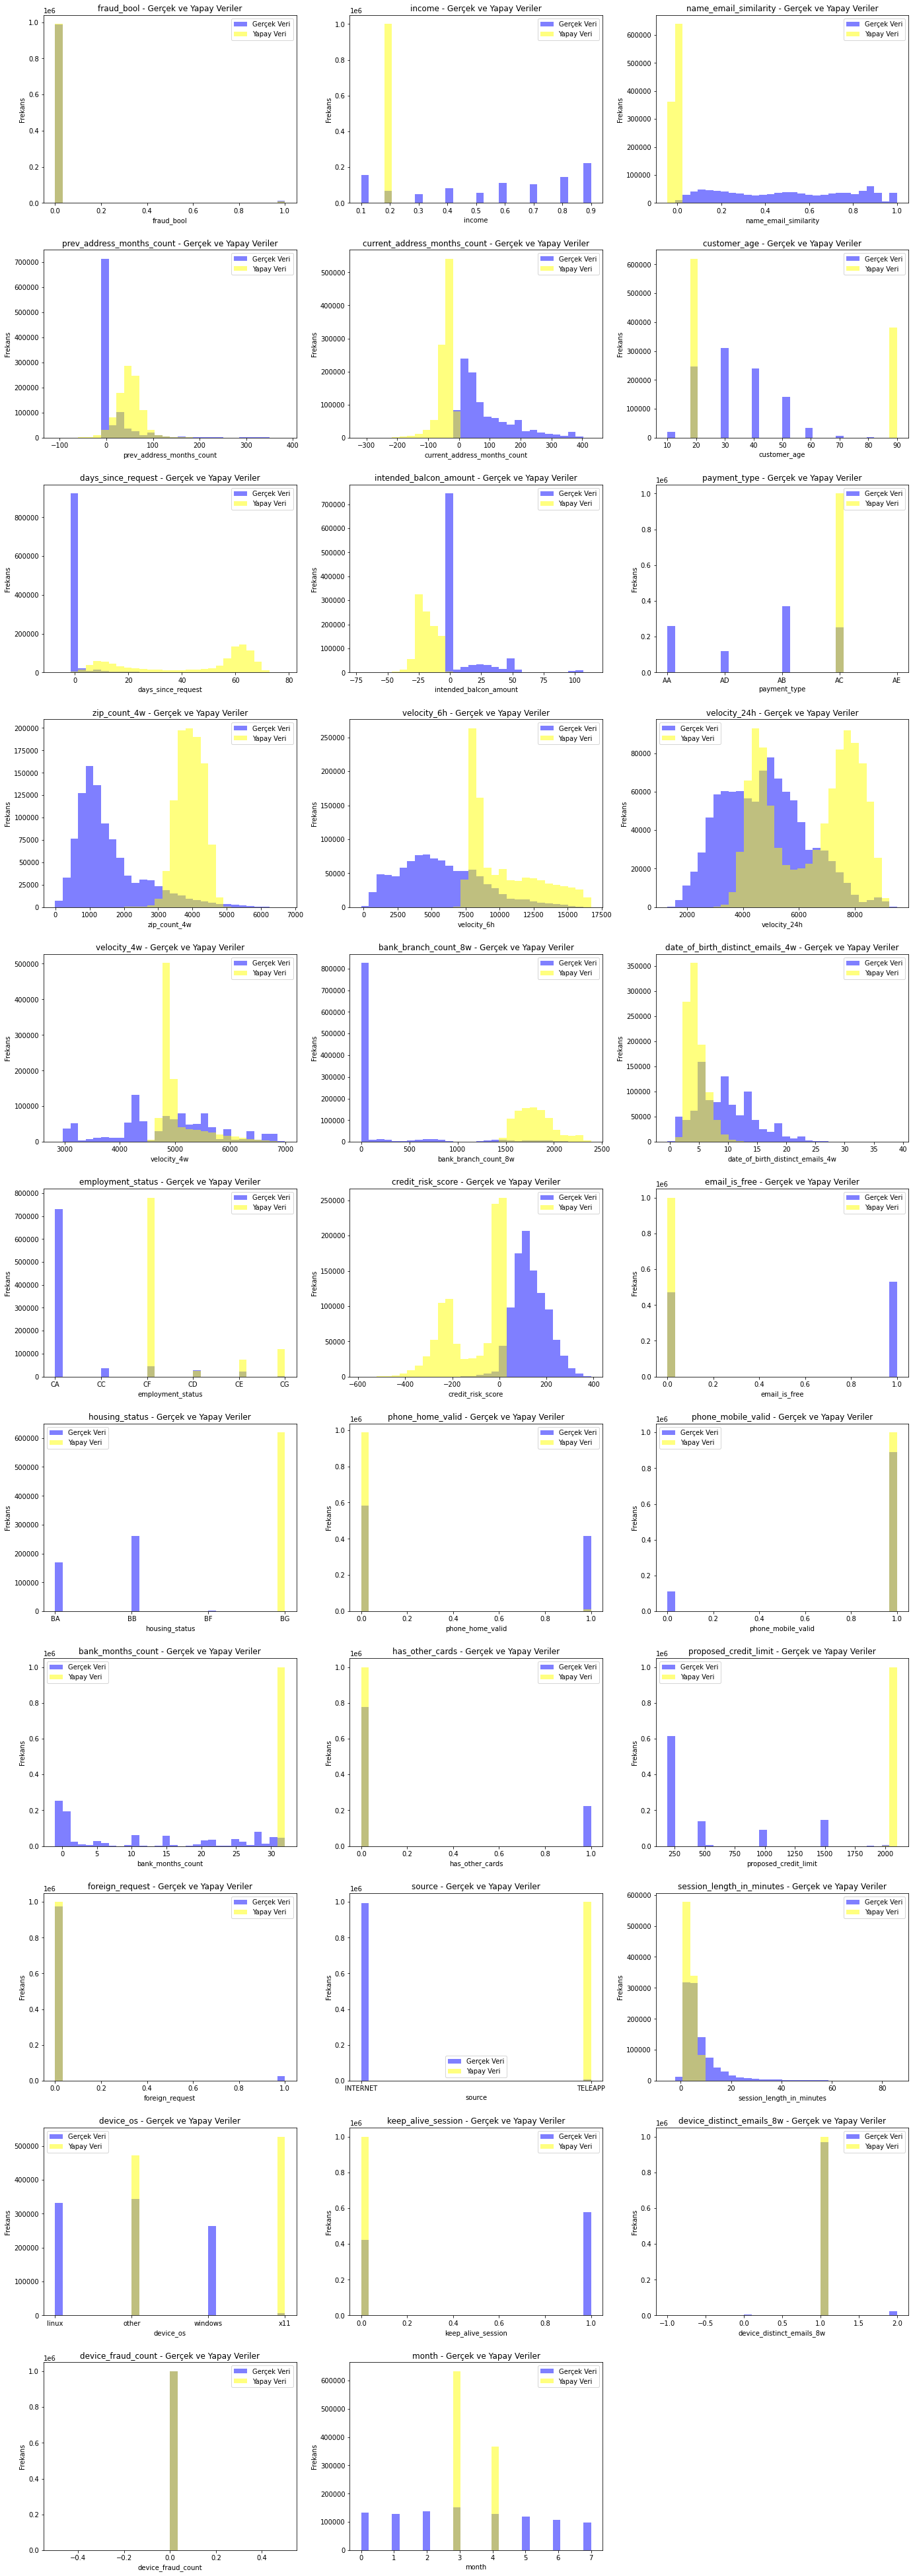

In [32]:
df = pd.read_csv('base.csv') 


features = df.columns

num_features = len(features)
num_columns = 3
num_rows = (num_features + num_columns - 1) // num_columns  

fig, axes = plt.subplots(num_rows, num_columns, figsize=(20, num_rows * 5))
fig.tight_layout(pad=5.0)  

for i, feature in enumerate(features):
    row = i // num_columns
    col = i % num_columns
    
    ax = axes[row, col]
    
    min_val = min(df[feature].min(), generated_df[feature].min())
    max_val = max(df[feature].max(), generated_df[feature].max())
    
    ax.hist(df[feature], bins=30, alpha=0.5, label='Gerçek Veri', color='blue', range=(min_val, max_val))
    ax.hist(generated_df[feature], bins=30, alpha=0.5, label='Yapay Veri', color='yellow', range=(min_val, max_val))
    
    ax.set_title(f'{feature} - Gerçek ve Yapay Veriler')
    ax.set_xlabel(feature)
    ax.set_ylabel('Frekans')
    ax.legend()

for j in range(len(features), num_rows * num_columns):
    fig.delaxes(axes[j // num_columns, j % num_columns])

plt.show()

## Yapay Verinin Kaydedilmesi

In [33]:
output_file_path = "large_generated_data.csv"
chunk_size = 100000 

for i in range(0, len(generated_df), chunk_size):
    generated_df.iloc[i:i+chunk_size].to_csv(output_file_path, mode='a', index=False, header=(i == 0))

print(f"Large generated data saved to {output_file_path}")

Large generated data saved to large_generated_data.csv
